<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 11

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.
* Creating a new StandardScaler for Gaussian Processes: https://stats.stackexchange.com/questions/364418/how-to-get-the-prediction-std-using-gaussian-process-in-scikit-learn
* The flower to explain the Iris dataset comes from this [source](https://www.ritchieng.com/machine-learning-iris-dataset/)

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
#plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Continuation of tutorial on supervised learning (again, no theory today!)
    - Multidimensional regression with Gaussian Processes and Artificial Neural Networks
* Classification with supervised learning: quick tutorial using Decision Trees and Support Vector Machines

**Reading material**: This notebook + (GPs in Section 17.3 of book; ANNs in Chapter 13)

## Today's lecture is also going to be more practical

Similarly to the previous lecture, we will focus on the practical aspects **without deriving the models yet**.

* Regression via supervised learning in multiple dimensions:
    - Today we will just focus only on **Gaussian Processes** using [scikit-learn](https://scikit-learn.org)

As we will see today, using ML models for multidimensional regression is very similar to the one-dimensional case we covered in the previous lectures.

## Creating a noiseless multidimensional dataset

Before we start, we need to consider a particular dataset for which we want to do regression.

As before, instead of downloading a particular dataset, let's create our own.

* There is a nice website listing many different benchmark functions used in optimization: https://www.sfu.ca/~ssurjano/optimization.html

We will learn some of them using Gaussian Processes...

In [2]:
# Line below is to enable live rotation of the surface plots.
%matplotlib notebook
#
from matplotlib import cm # to change colors of surface plots
#
# Let's define some functions that are often used to benchmark
# algorithms (especially in optimization)
def schwefel( x ):
    function_name = 'Schwefel' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        y[ii] = 418.9829*n_features - sum( x[ii,:] * np.sin( np.sqrt( abs( x[ii,:] ))))
    return (np.atleast_1d(y), function_name)
#
# The next cell (hidden in presentation) includes a few more functions (so that you can play with this notebook).

In [3]:
def levy( x ):
    function_name = 'Levy' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        z = 1 + (x[ii,:] - 1) / 4
        y[ii] = (np.sin( np.pi * z[0] )**2
            + sum( (z[:-1] - 1)**2 * (1 + 10 * np.sin( np.pi * z[:-1] + 1 )**2 ))
            +       (z[-1] - 1)**2 * (1 + np.sin( 2 * np.pi * z[-1] )**2 ))
    return (np.atleast_1d(y), function_name)
#
def ackley( x, a=20, b=0.2, c=2*np.pi ):
    function_name = 'Ackley' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        s1 = sum( x[ii,:]**2 )
        s2 = sum( np.cos( c * x[ii,:] ))
        y[ii] = -a*np.exp( -b*np.sqrt( s1 / n_features )) - np.exp( s2 / n_features ) + a + np.exp(1)
    return (np.atleast_1d(y), function_name)
#
def rosenbrock( x ):  # rosen.m
    function_name = 'Rosenbrock' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        x0 = x[ii,:-1]
        x1 = x[ii,1:]
        y[ii] = (sum( (1 - x0) **2 )
            + 100 * sum( (x1 - x0**2) **2 ))
    return (np.atleast_1d(y), function_name)
#

def griewank( x, fr=4000 ):
    function_name = 'Griewank' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    j = np.arange( 1., n_features+1 )
    for ii in range(n_points):
        s = sum( x[ii,:]**2 )
        p = np.prod( np.cos( x[ii,:] / np.sqrt(j) ))
        y[ii] = s/fr - p + 1
    return (np.atleast_1d(y), function_name)
#
def rastrigin( x ):  # rast.m
    function_name = 'Rastrigin' # to output name of function
    x = np.asarray_chkfinite(x)  # ValueError if any NaN or Inf
    if x.ndim == 1:
        x = np.reshape(x,(-1,2)) # reshape into 2d array
    #
    n_points, n_features = np.shape(x)
    y = np.empty((n_points,1))
    #
    for ii in range(n_points):
        y[ii] = 10*n_features + sum( x[ii,:]**2 - 10 *
                                np.cos( 2 * np.pi * x[ii,:] ))
    return (np.atleast_1d(y), function_name)
#
# end of functions for benchmark.

#
seed = 1987 # set a random seed to replicate results
np.random.seed(seed)

<a id='#create_dataset'></a>

Consider equally spaced sampling points to evaluate the function, as we did before for the 1D case.

In [4]:
# Uniform grid of points for two-dimensional input
n_points_per_dimension = 50
x1 = np.linspace(-10.0, 10.0, n_points_per_dimension)
x2 = np.linspace(-10.0, 10.0, n_points_per_dimension)
# x3 = np.linspace(-10.0, 10.0, n_points_per_dimension) # if the input was 3D

X1_grid, X2_grid = np.meshgrid(x1, x2) # creates a grid of points that is necessary to plot surfaces
#X1_grid, X2_grid, X3_grid = np.meshgrid(x1, x2, x3) # e.g. for 3D input

print("Note that the X1_grid (and X2_grid) are 2D arrays with the following size:\n", np.shape(X1_grid))

# Input points reshaped for Pandas dataframe
Data_X = np.array([X1_grid, X2_grid]).reshape(2, -1).T
#Data_X = np.array([X1_grid, X2_grid, X3_grid]).reshape(3, -1).T

Note that the X1_grid (and X2_grid) are 2D arrays with the following size:
 (50, 50)


<a id='#choose_other_function'></a>

Now evaluate the function of interest (e.g. Schwefel function) at these input points.

In [5]:
# Output data created from one of the benchmark functions:
# levy, ackley, rosenbrock, schwefel, griewank, rastrigin
Data_y, function_name = schwefel(Data_X) # calculate the output vector Data_y (1D output) from input data (2D input)

print("The output of the function is a vector with size:\n", np.shape(Data_y))

# Reshape output data for use in Surface plot:
Y_grid = np.reshape(Data_y,np.shape(X1_grid))

print("So, we reshape the output vector into a 2D array needed to plot surfaces:\n", np.shape(Y_grid))

# Set the color scheme used in every plot:
set_cm = cm.cool # viridis, inferno, copper, PuBu, cool, coolwarm, hsv

The output of the function is a vector with size:
 (2500, 1)
So, we reshape the output vector into a 2D array needed to plot surfaces:
 (50, 50)


Let's plot the function in a few different ways:
* Left subplot: 3D surface of the function
* Right subplot: a wireframe of the surface (no colors)

<IPython.core.display.Javascript object>


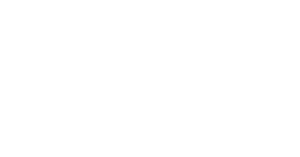

In [6]:
fig1 = plt.figure(figsize=plt.figaspect(0.5)); ax1 = [];
# Subplot 1 (left) of Figure 1
ax1.append(fig1.add_subplot(1, 2, 1, projection='3d')) # just a way to use the same variable for all axes of fig1.
# Surface plot:
surf = ax1[0].plot_surface(X1_grid, X2_grid, Y_grid, cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax1[0].set_xlabel('$x_1$', fontsize=15)
ax1[0].set_ylabel('$x_2$', fontsize=15)
ax1[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax1[0].set_title("%s function" % function_name, fontsize=15)

# Subplot 2 (right) of Figure 1
ax1.append(fig1.add_subplot(1, 2, 2, projection='3d'))
# Plot a 3D wireframe (no colors)
ax1[1].plot_wireframe(X1_grid, X2_grid, Y_grid, rstride=5, cstride=5)
ax1[1].set_xlabel('$x_1$', fontsize=15)
ax1[1].set_ylabel('$x_2$', fontsize=15)
ax1[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax1[1].set_title("%s function" % function_name, fontsize=15)
#plt.tight_layout() # if we want to enlarge the figures, but sometimes this leads to label occlusion.
plt.close(fig1)

<IPython.core.display.Javascript object>


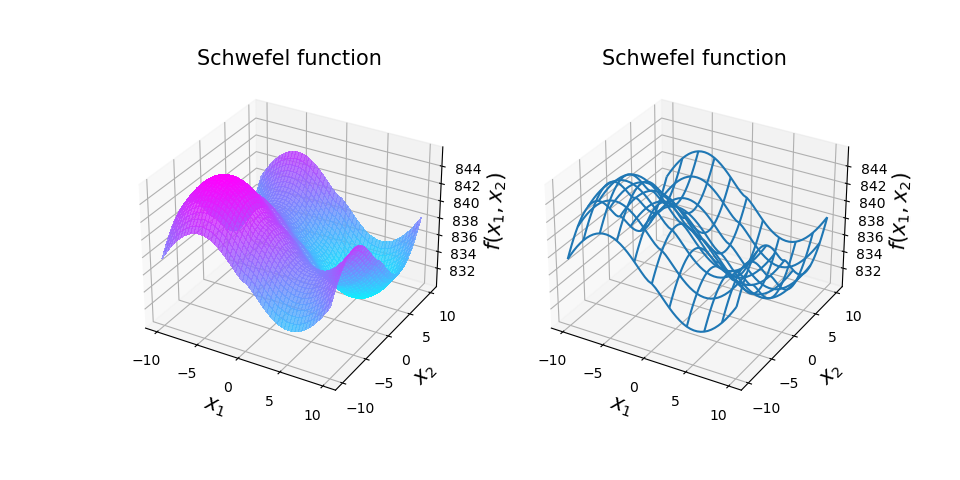

In [7]:
fig1

In the next figure, we show a contour plot of the same function.

<IPython.core.display.Javascript object>


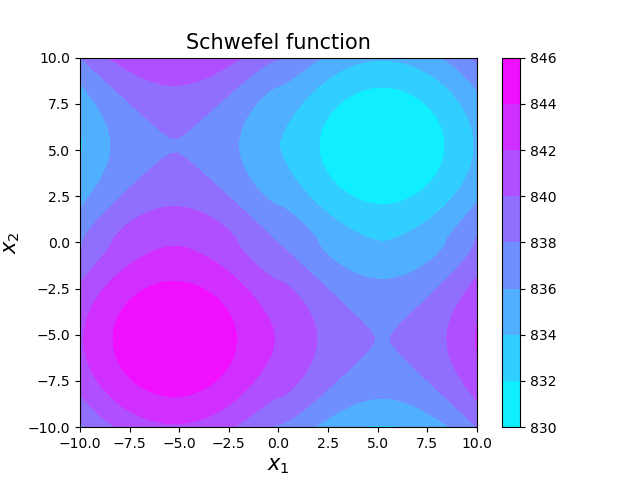

In [8]:
fig2, ax2 = plt.subplots()
cset = ax2.contourf(X1_grid, X2_grid, Y_grid, cmap=set_cm)
ax2.set_xlabel('$x_1$', fontsize=15)
ax2.set_ylabel('$x_2$', fontsize=15)
ax2.set_title("%s function" % function_name, fontsize=15)
fig2.colorbar(cset, ax=ax2)

### Exercise 1

Go to this [cell](##choose_other_function) and choose a different function to be learned. Run the notebook until here to see how the function looks like.

#### Note on the Pandas DataFrame included in the "docs" folder

* The "docs" folder contains a file called "data_noiseless_schwefel_2D_regression.csv" with a Pandas DataFrame with data obtained from the Schwefel function in the domain $x \in [-10, 10]$ without considering noise.

So, let's load this DataFrame and use it for training a Gaussian Process.

To refresh your memory, the DataFrame was saved as a Pickle file (compressed format) and it was obtained by running the notebook until this point, and then using the following code:

``` python
import pandas as pd
input_dictionary = {
            'x1' : Data_X[:,0], # feature 'x1'
            'x2' : Data_X[:,1], # feature 'x2'
            #'x3' : Data_X[:,2], # you could have more features if the function accepts higher dimensions
            'y1' : Data_y[:,0] # target 'y1'
            }
# Then, we create a Pandas data frame:
df = pd.DataFrame(input_dictionary)
# Save DataFrame in "docs" folder as Pickle file:
df.to_pickle("docs/data_noiseless_schwefel_2D_regression.pkl")
```

In [9]:
import pandas as pd
df = pd.read_pickle("docs/data_noiseless_schwefel_2D_regression.pkl") # read pandas DataFrame
function_name = 'Schwefel' # The dataframe was created using the Schwefel function

print("Show the DataFrame in the docs folder:\n", df)

Show the DataFrame in the docs folder:
              x1    x2          y1
0    -10.000000 -10.0  837.552129
1     -9.591837 -10.0  838.185887
2     -9.183673 -10.0  838.777493
3     -8.775510 -10.0  839.323512
4     -8.367347 -10.0  839.820614
...         ...   ...         ...
2495   8.367347  10.0  836.110986
2496   8.775510  10.0  836.608088
2497   9.183673  10.0  837.154107
2498   9.591837  10.0  837.745713
2499  10.000000  10.0  838.379471

[2500 rows x 3 columns]


Although we introduced pandas in Lecture 2, you should keep exploring how it works...

For example, there are a few different ways to access the data of a DataFrame.

The notes below (not shown in the presentation), show you 3 different ways:

1. Direct way to select columns & rows by how they were labeled originaly


2. DataFrame.loc to select columns & rows by Name


3. DataFrame.iloc to select columns & rows by Index Positions (integer numbers)

In [10]:
# Let's access every row of feature 'x1' and of target 'y1':
way1 = df[['x1','y1']] # direct way

way2 = df.loc[:,['x1','y1']] # using the labels of rows and columns

way3 = df.iloc[:,[0,2]] # using indices (integers) of rows and columns

print('way 1 =\n', way1, '\n\n') # the '\n' is to make a new line for visualization purposes only.
print('way 2 =\n', way2, '\n\n')
print('way 3 =\n', way3, '\n\n')

way 1 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.608088
2497   9.183673  837.154107
2498   9.591837  837.745713
2499  10.000000  838.379471

[2500 rows x 2 columns] 


way 2 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.608088
2497   9.183673  837.154107
2498   9.591837  837.745713
2499  10.000000  838.379471

[2500 rows x 2 columns] 


way 3 =
              x1          y1
0    -10.000000  837.552129
1     -9.591837  838.185887
2     -9.183673  838.777493
3     -8.775510  839.323512
4     -8.367347  839.820614
...         ...         ...
2495   8.367347  836.110986
2496   8.775510  836.

In [11]:
# Now let's access rows 2 until 5 (inclusive) of feature 'x2' an target 'y1':

# I think we can't do that by the direct way (correct me if I am wrong)
way2 = df.loc[2:5,['x2','y1']] # using the labels of data. Note that here when we write 2:5 (it includes)
                               # row with index 5

way3 = df.iloc[2:6,[1,2]] # using indices (integers) of the data note that we write 2:6 to include 5,
                          # which differs from way2 (!).
# way3 = df.iloc[2:6,1:3] # Alternative to accessing 'x2' and 'y1' by writing 1:3 instead of [1,2]

print('Specific rows, way 2 =\n', way2, '\n\n')
print('Specific rows, way 3 =\n', way3, '\n\n')

Specific rows, way 2 =
      x2          y1
2 -10.0  838.777493
3 -10.0  839.323512
4 -10.0  839.820614
5 -10.0  840.265605 


Specific rows, way 3 =
      x2          y1
2 -10.0  838.777493
3 -10.0  839.323512
4 -10.0  839.820614
5 -10.0  840.265605 




In [12]:
# Separate the features and targets into two different variables:
X_data = df.loc[:,['x1','x2']].values # note that we ask for all the values, not a subset of the DataFrame
y_data = df.loc[:,'y1'].values

# Recreate the grid of points that is necessary to plot surfaces (by reshaping)
X1_grid = np.reshape(X_data[:,0],( round( np.sqrt(len(X_data)) ), round( np.sqrt(len(X_data)) ) ))
X2_grid = np.reshape(X_data[:,1],( round( np.sqrt(len(X_data)) ), round( np.sqrt(len(X_data)) ) ))
Y_grid = np.reshape(y_data,( round( np.sqrt(len(X_data)) ), round( np.sqrt(len(X_data)) ) ))

print("Features loaded from the saved DataFrame:\n", X_data)
print("\nTarget loaded from the saved DataFrame:\n", y_data)

Features loaded from the saved DataFrame:
 [[-10.         -10.        ]
 [ -9.59183673 -10.        ]
 [ -9.18367347 -10.        ]
 ...
 [  9.18367347  10.        ]
 [  9.59183673  10.        ]
 [ 10.          10.        ]]

Target loaded from the saved DataFrame:
 [837.55212937 838.18588668 838.77749275 ... 837.15410725 837.74571332
 838.37947063]


## Multidimensional regression with Gaussian Processes

Let's create a Gaussian Process Regression model for the multidimensional data we loaded from that Pandas dataframe.

<a id='#split_dataset'></a>

As usual, we split the dataset into training and testing sets.

* For now, we split the data with the following ratio: 2% for training set, and 98% for testing set

Note: the commonly used ratio is 75% for training and 25% for testing, but we will use Gaussian Processes and they can learn from very little data.

In [13]:
# Train/test split like we did before!
from sklearn.model_selection import train_test_split

testset_ratio = 0.98 # ratio of test set points from the dataset

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=testset_ratio,random_state=seed)
#

Now we can train the GP model on the training data and test it on the testing data, just like we did in the previous lectures.

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

# Define the kernel function
kernel = ConstantKernel(1.0, (1e-4, 1e4)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
#kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above
                                    #(scikit-learn assumes constant
                                    # variance if you just write RBF
                                    # without the constant kernel or
                                    # without multiplying by 1.0)

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha

# Fit to data using Maximum Likelihood Estimation of the parameters
gp_model.fit(X_train, y_train) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_data_GPpred, sigma_data_GPpred = gp_model.predict(X_data, return_std=True)

# Predict for test set (for error metric)
y_test_GPpred, sigma_test_GPpred = gp_model.predict(X_test, return_std=True)

/home/mabessa/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/mabessa/miniconda3/envs/3dasm/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


**IMPORTANT**: You probably got a warning message...

This is not just a minor "detail". It has important implications!
* This is a direct consequence of us not **pre-processing** the data adequately.

Before learning how to pre-process the data, let's visualize our GPR model and compare it to the ground truth function.

<IPython.core.display.Javascript object>


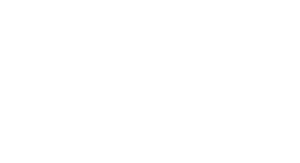

In [15]:
fig3_WRONG = plt.figure(figsize=plt.figaspect(0.5)); ax3_WRONG = []
# Subplot 1 (left): ground truth
ax3_WRONG.append(fig3_WRONG.add_subplot(1, 2, 1, projection='3d'))
surf = ax3_WRONG[0].plot_surface(X1_grid, X2_grid, Y_grid,
                                 cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3_WRONG[0].set_xlabel('$x_1$', fontsize=15)
ax3_WRONG[0].set_ylabel('$x_2$', fontsize=15)
ax3_WRONG[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3_WRONG[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# Subplot 2 (right): GPR approximation
ax3_WRONG.append(fig3_WRONG.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax3_WRONG[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                                 cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3_WRONG[1].set_xlabel('$x_1$', fontsize=15)
ax3_WRONG[1].set_ylabel('$x_2$', fontsize=15)
ax3_WRONG[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3_WRONG[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax3_WRONG[1].scatter(X_train[:,0], X_train[:,1], y_train, marker='o', color='red', label="training points")
ax3_WRONG[1].legend(loc='upper center')
#plt.tight_layout()
plt.close(fig3_WRONG) # close figure to open it in next cell.

<IPython.core.display.Javascript object>


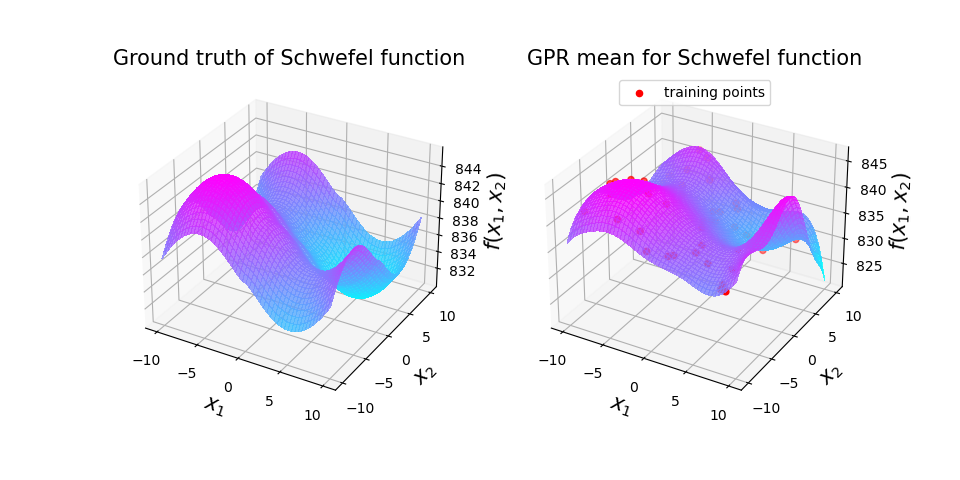

In [16]:
fig3_WRONG # show figure illustrating the issues of not scaling the data appropriately!

This does not look great, especially at the boundary!

<IPython.core.display.Javascript object>


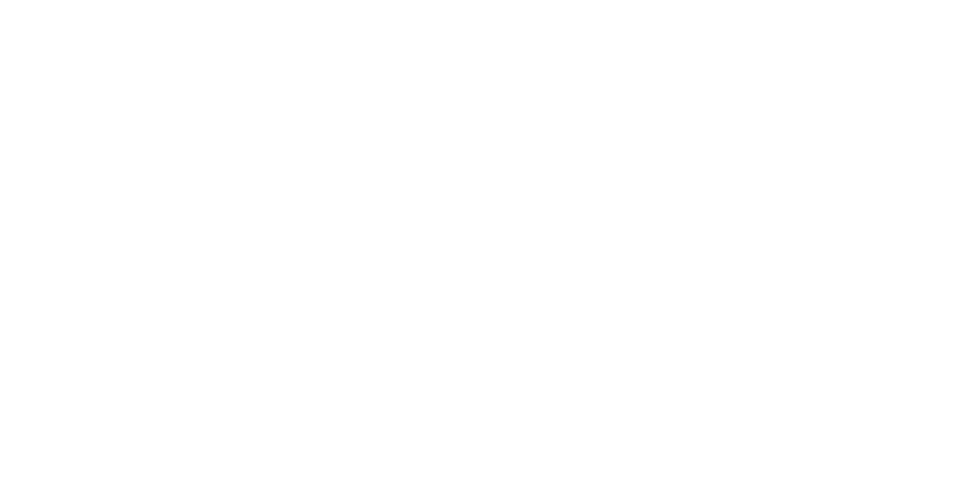

In [17]:
fig4_WRONG = plt.figure(figsize=plt.figaspect(0.5)); ax4_WRONG = []
# Create Contour plot:
ax4_WRONG.append(fig4_WRONG.add_subplot(1, 3, 1))
cset = ax4_WRONG[0].contourf(X1_grid, X2_grid, Y_grid, cmap=set_cm)
ax4_WRONG[0].set_xlabel('$x_1$')
ax4_WRONG[0].set_ylabel('$x_2$')
ax4_WRONG[0].set_title("Ground truth of %s function" % function_name)
fig4_WRONG.colorbar(cset, ax=ax4_WRONG[0])

# Create Contour plot:
ax4_WRONG.append(fig4_WRONG.add_subplot(1, 3, 2))
cset = ax4_WRONG[1].contourf(X1_grid, X2_grid, Y_grid_data_GPpred, cmap=set_cm)
ax4_WRONG[1].set_xlabel('$x_1$')
ax4_WRONG[1].set_ylabel('$x_2$')
ax4_WRONG[1].set_title("GPR mean for %s function" % function_name)
fig4_WRONG.colorbar(cset, ax=ax4_WRONG[1])

# Create Contour plot:
ax4_WRONG.append(fig4_WRONG.add_subplot(1, 3, 3))

SIGMA_grid_data_GPpred = np.reshape(sigma_data_GPpred,np.shape(X1_grid))

cset = ax4_WRONG[2].contourf(X1_grid, X2_grid, SIGMA_grid_data_GPpred, cmap=set_cm)
ax4_WRONG[2].set_xlabel('$x_1$')
ax4_WRONG[2].set_ylabel('$x_2$')
ax4_WRONG[2].set_title("GPR STDV for %s function" % function_name)
fig4_WRONG.colorbar(cset, ax=ax4_WRONG[2])

plt.tight_layout()
plt.close(fig4_WRONG) # close figure to open it in next cell.

<IPython.core.display.Javascript object>


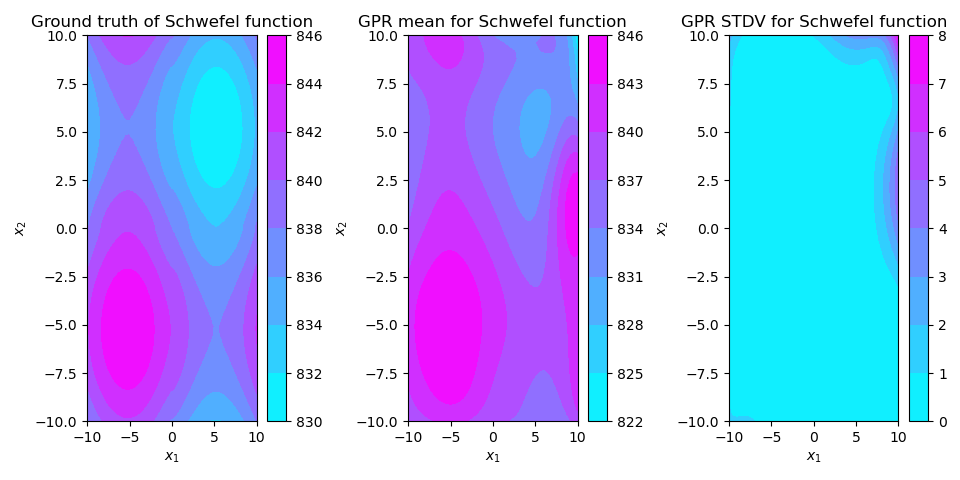

In [18]:
fig4_WRONG # plot the same figure but using countour plots

Now we see clearly that the uncertainty is significant at the boundary!

This happened because the output values are large and we did not **pre-process** the dataset appropriately!

* It is good practice to **scale the dataset**.

Scikit-learn has implemented different [preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html) strategies. **Check the documentation**.

The most common strategy is to standardize the dataset using the StandardScaler:

* StandardScaler: each feature is transformed to have zero-mean and unit standard deviation. In other words, the data becomes normally distributed (it is transformed). **Standardization of datasets is a common requirement for many machine learning models**.

There are other scaling strategies. For example, the simplest one is to use the MinMaxScaler:

* MinMaxScaler: this transformation is simpler, as it just scales the data such that the maximum and minimum value are bounded to specified values (by default between 0 and 1). This keeps the distribution of the data (non distorting), i.e. it **does not** reduce the importance of outliers.

Here's an example of how to scale the $\mathcal{D}_x$ data using the MinMaxScaler (between -1 and 1, instead of between 0 and 1):

``` python
from sklearn.preprocessing import MinMaxScaler
# Scaling inputs with a MinMax Scaler (between -1 and 1):
scaler_x = MinMaxScaler(feature_range=(-1,1))
scaler_x.fit(X_train)
#
X_train_scaled=scaler_x.transform(X_train)
X_test_scaled=scaler_x.transform(X_test)
X_data_scaled=scaler_x.transform(X_data)
````

In [19]:
from sklearn.preprocessing import StandardScaler
# Scaling inputs with a Standard Scaler:
scaler_x = StandardScaler()
scaler_x.fit(X_train) # fit the scaler to the input data
#
X_train_scaled=scaler_x.transform(X_train) # scale the input training data
X_test_scaled=scaler_x.transform(X_test)  # scale the input testing data
X_data_scaled=scaler_x.transform(X_data) # scale the input data (the whole dataset)

idx = 0 # Choose the point you want to check the value (we could also plot the entire dataset.)
print("X_data[%i] is =" % idx, X_data[idx])
print("X_data_scaled[%i] is =" % idx, X_data_scaled[idx])

X_data[0] is = [-10. -10.]
X_data_scaled[0] is = [-1.79658824 -1.50411611]


In [20]:
# Now scaling outputs also using StandardScaler:
y_train = y_train.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
y_test = y_test.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
y_data = y_data.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#
scaler_y = StandardScaler()
scaler_y.fit(y_train) # fit the scaler to the output data
#
y_train_scaled=scaler_y.transform(y_train) # scale the output training data
y_test_scaled=scaler_y.transform(y_test)  # scale the output testing data
y_data_scaled=scaler_y.transform(y_data) # scale the output data (the whole dataset)

idx = 0 # Choose the point you want to check the value (we could also plot the entire dataset.)
print("y_data[%i] is =" % idx, y_data[idx])
print("y_data_scaled[%i] is =" % idx, y_data_scaled[idx])

y_data[0] is = [837.55212937]
y_data_scaled[0] is = [-0.10898576]


In [21]:
# Create the GP model again (same kernel, same parameters and same optimization process!)
kernel = ConstantKernel(1.0, (1e-4, 1e4)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha

# The ONLY difference is that we will train the model on SCALED inputs and outputs
gp_model.fit(X_train_scaled, y_train_scaled) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_data_GPpred_scaled, sigma_data_GPpred_scaled = gp_model.predict(X_data_scaled, return_std=True)
# IMPORTANT: we need to scale the predictions for the mean of the output back to the original scale!
y_data_GPpred = scaler_y.inverse_transform(y_data_GPpred_scaled) # mean
# IMPORTANT: we need to do the same for the standard deviation of the output, but in this case we have to subtract
#            by the mean of the training data because the standard deviation is not transformed by the
#            StandardScaler in the same way as the mean! In the Homework you will derive this...
sigma_data_GPpred = scaler_y.inverse_transform(sigma_data_GPpred_scaled.reshape(-1, 1)) - np.mean(y_train)
my_sigma_data_GPpred = sigma_data_GPpred_scaled.reshape(-1, 1)*np.std(y_train)

# Predict for test set (for error metric)
y_test_GPpred_scaled, sigma_test_GPpred_scaled = gp_model.predict(X_test_scaled, return_std=True)
# Scale mean and std back, as above.
y_test_GPpred = scaler_y.inverse_transform(y_test_GPpred_scaled)
sigma_test_GPpred = scaler_y.inverse_transform(sigma_test_GPpred_scaled.reshape(-1, 1)) - np.mean(y_train)

<IPython.core.display.Javascript object>


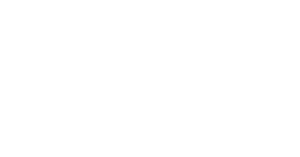

In [22]:
fig3 = plt.figure(figsize=plt.figaspect(0.5)); ax3 = []
# Subplot 1 (left): ground truth
ax3.append(fig3.add_subplot(1, 2, 1, projection='3d'))
surf = ax3[0].plot_surface(X1_grid, X2_grid, Y_grid,
                           cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3[0].set_xlabel('$x_1$', fontsize=15)
ax3[0].set_ylabel('$x_2$', fontsize=15)
ax3[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# Subplot 2 (right): GPR approximation
ax3.append(fig3.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax3[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                                       cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax3[1].set_xlabel('$x_1$', fontsize=15)
ax3[1].set_ylabel('$x_2$', fontsize=15)
ax3[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax3[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax3[1].scatter(X_train[:,0], X_train[:,1], y_train, marker='o', color='red', label="training points")
ax3[1].legend(loc='upper center')
#plt.tight_layout()
plt.close(fig3) # close figure to open it in next cell.

<IPython.core.display.Javascript object>


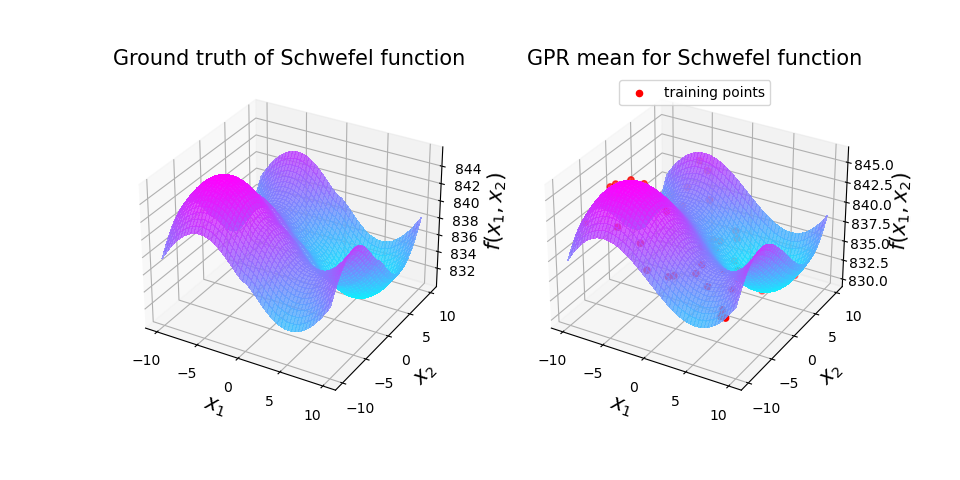

In [23]:
fig3

We can also plot this information via contour plots, and show not only the mean predicted by GPR but also the standard deviation.

Note: you can also overlay the 95% confidence intervals in a surface plot, but usually it becomes really cluttered (so we didn't do it).

<IPython.core.display.Javascript object>


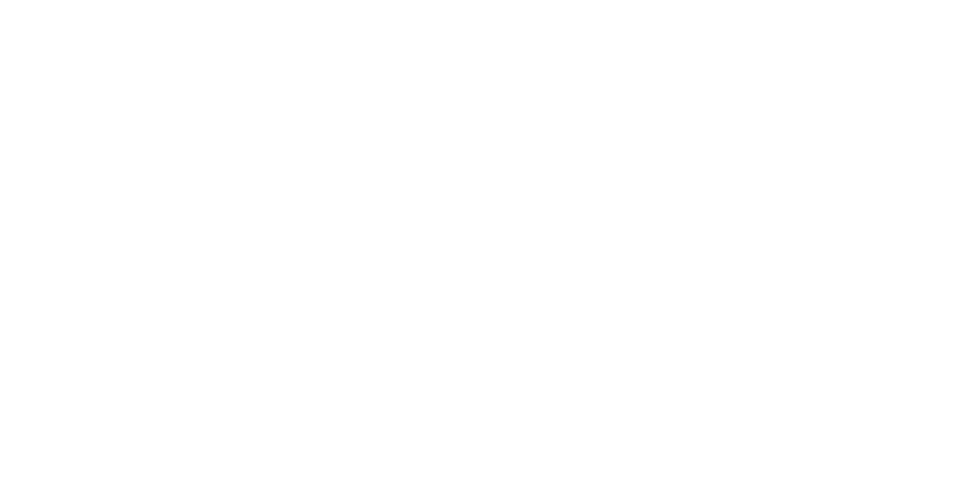

In [25]:
fig4 = plt.figure(figsize=plt.figaspect(0.5)); ax4 = []
# Create Contour plot:
ax4.append(fig4.add_subplot(1, 3, 1))
cset = ax4[0].contourf(X1_grid, X2_grid, Y_grid, cmap=set_cm)
ax4[0].set_xlabel('$x_1$')
ax4[0].set_ylabel('$x_2$')
ax4[0].set_title("Ground truth of %s function" % function_name)
fig4.colorbar(cset, ax=ax4[0])

# Create Contour plot:
ax4.append(fig4.add_subplot(1, 3, 2))
cset = ax4[1].contourf(X1_grid, X2_grid, Y_grid_data_GPpred, cmap=set_cm)
ax4[1].set_xlabel('$x_1$')
ax4[1].set_ylabel('$x_2$')
ax4[1].set_title("GPR mean for %s function" % function_name)
fig4.colorbar(cset, ax=ax4[1])

# Create Contour plot:
ax4.append(fig4.add_subplot(1, 3, 3))

SIGMA_grid_data_GPpred = np.reshape(sigma_data_GPpred,np.shape(X1_grid))

cset = ax4[2].contourf(X1_grid, X2_grid, SIGMA_grid_data_GPpred, cmap=set_cm)
ax4[2].set_xlabel('$x_1$')
ax4[2].set_ylabel('$x_2$')
ax4[2].set_title("GPR STDV for %s function" % function_name)
fig4.colorbar(cset, ax=ax4[2])

plt.tight_layout()
plt.close(fig4) # close figure to open it in next cell.

<IPython.core.display.Javascript object>


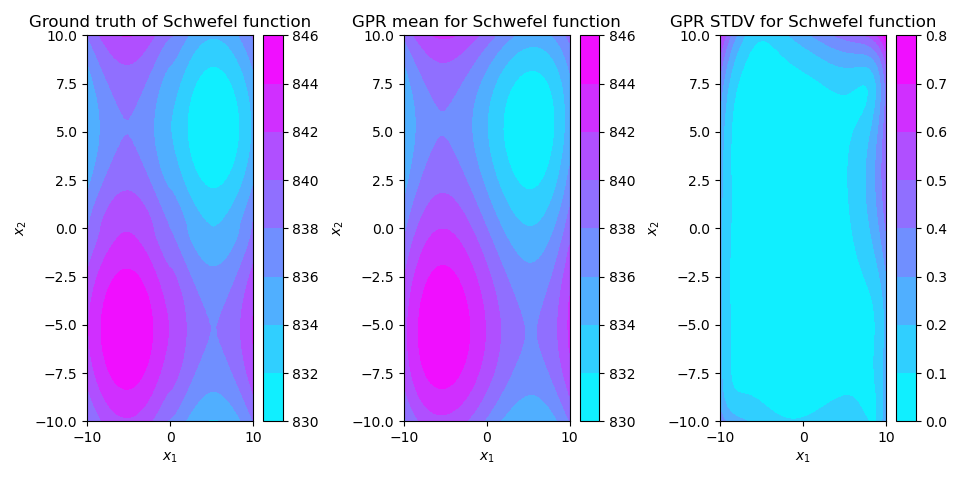

In [26]:
fig4 # show same results but using contour plots.

It's quite remarkable that GPR predicts this function almost perfectly while using only 50 points! This is equivalent to using just $\sqrt{50}\approx 7$ points per dimension!

Let's now compute the $R^2$ error metric for the GPR approximation.

In [27]:
from sklearn.metrics import r2_score # Import error metrics

# Compute MSE and R2 for the GP model
gp_r2_value = r2_score(y_test, y_test_GPpred)

print('R2 score for GPR = ', gp_r2_value)

R2 score for GPR =  0.9956601182103326


#### An important issue in Gaussian processes: lack of scalability

* Redo the GP regression of the Schwefel function but now using 75% of the data for training.

The notes below show the complete code. You probably noticed it took a while to train the GP...

Unfortunately, it is not uncommon for a Machine Learning problem to have millions of data points... But GPs cannot deal with this because the computational cost scales cubically with the number of datapoints: $\mathcal{O}(n^3)$.

The reason for this issue comes from the need to invert the covariance matrix, which is a $n\times n$ matrix where $n$ is the number of training points.

* **To keep in mind**: Gaussian processes are very powerful for small datasets, but they do not scale well for large datasets.

#### Experimenting with GPs to confirm the scalability issue.

Let's try to train the GP using more data. For example, we can to go to this [cell](##split_dataset) and change the testset_ratio to 25% and then run the remaining cells to train the GP and plot the surface to compare with the Ground truth.

Depending on the computer you are using, this can take a while (if your computer can handle it, then keep increasing the number of points per dimension: for example use 100 instead of the 50 we used in this [cell](##create_dataset))...

This scalability issue is **a big limitation** associated to GPs. There are a few modifications one can do to the method, e.g. creating a sparse version, but they still do not scale as well as Artificial Neural Networks.

``` python
# CODE TO ILLUSTRATE THE LACK OF SCALABILITY OF GPR
# Create dataset
n_points_per_dimension = 50 # if your computer can still handle this amount of data, increase this number.
x1 = np.linspace(-10.0, 10.0, n_points_per_dimension)
x2 = np.linspace(-10.0, 10.0, n_points_per_dimension)
X1_grid, X2_grid = np.meshgrid(x1, x2) # creates a grid of points that is necessary to plot surfaces
X_data = np.array([X1_grid, X2_grid]).reshape(2, -1).T
y_data, function_name = schwefel(X_data) # calculate the output of the Schwefel function

scaler_x = StandardScaler()
scaler_x.fit(X_train) # fit the scaler to the input data
X_train_scaled=scaler_x.transform(X_train) # scale the input training data
X_test_scaled=scaler_x.transform(X_test)  # scale the input testing data
X_data_scaled=scaler_x.transform(X_data) # scale the input data (the whole dataset)
#
y_train = y_train.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
y_test = y_test.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
y_data = y_data.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
scaler_y = StandardScaler()
scaler_y.fit(y_train) # fit the scaler to the output data
#
y_train_scaled=scaler_y.transform(y_train) # scale the output training data
y_test_scaled=scaler_y.transform(y_test)  # scale the output testing data
y_data_scaled=scaler_y.transform(y_data) # scale the output data (the whole dataset)

# Reshape output data for use in Surface plot:
Y_grid = np.reshape(y_data,np.shape(X1_grid))

# Split dataset into training and testing
testset_ratio = 0.25 # ratio of test set points from the dataset
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size=testset_ratio,random_state=seed)

# The remaining code is the same as in the Lecture (with scaling for the entire dataset).
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20)

# The ONLY difference is that we will train the model on SCALED inputs (not outputs)
gp_model.fit(X_train_scaled, y_train_scaled) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting)
y_data_GPpred_scaled = gp_model.predict(X_data_scaled) # NOTE THAT THE MODEL OUTPUTS ARE SCALED
y_data_GPpred = scaler_y.inverse_transform(y_data_GPpred_scaled)

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')
```

# <font color='red'>HOMEWORK</font>

Redo the Gaussian Processes Regression (GPR) of the Schwefel function for these conditions:
1. Training for data where you only scale the **inputs** using the StandardScaler. You get the same warning message (convergence difficulties to find the parameters of the kernel). **Why?**
    
2. Training for data where you only scale the **outputs** before training. This time your predictions are as good as the ones obtained when scaling both the inputs and the outputs. **Why?**
    
3. Create your own StandardScaler class achieving the same as scikit-learn's StandardScaler, but where the inverse_transform for the standard deviation does not need to be corrected like we did in the Lecture.

# Solution to the Homework

1. Code to answer question 1 (scaling only inputs):

``` python
# CODE TO ANSWER QUESTION 1 OF THE HOMEWORK FOR THIS LECTURE
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20)

# The ONLY difference is that we will train the model on SCALED inputs (not outputs)
gp_model.fit(X_train_scaled, y_train) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting)
y_data_GPpred = gp_model.predict(X_data_scaled)

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')

```

By plotting this we see that there are still convergence issues because the inputs of the Schwefel function are within reasonable bounds: $x_1 \in [-10, 10]$ and $x_2 \in [-10, 10]$. So, even if we scale the inputs, the difference will not be very large!

---

2. Code to answer question 2

``` python
# CODE TO ANSWER QUESTION 2 OF THE HOMEWORK FOR THIS LECTURE
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20)

# The ONLY difference is that we will train the model on SCALED inputs (not outputs)
gp_model.fit(X_train, y_train_scaled) # here I am not scaling the target variable; only the features.

# Make the prediction on the entire dataset (for plotting)
y_data_GPpred_scaled = gp_model.predict(X_data) # NOTE THAT THE MODEL OUTPUTS ARE SCALED
y_data_GPpred = scaler_y.inverse_transform(y_data_GPpred_scaled)

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')

```

By plotting this we see that it works well! Scaling the output is important for the Schwefel function because for the domain that we are considering the output is within the following bounds: $y \in [830, 846]$. This is a reasonable large value, which makes it harder to optimize the likelihood!

**Conclusion**: Usually, scaling the data doesn't *hurt* but it can really help! Pre-processing your datasets with appropriate scalers for both inputs and outputs is pretty important for many methods.

* Short note: A few methods do not care if you scale the data (decision trees are a great example). But again, if you use an appropriate scaler, it rarely makes things worst. So, most of the time, scaling the data is good practice.

---

3. Code to create our own version of the StandardScaler where the standard deviation of the output is scaled correctly.

``` python
# CODE TO ANSWER QUESTION 3 OF THE HOMEWORK FOR THIS LECTURE
# Let's create a class called MyStandardScaler where we correct the inverse_transform for the std
class MyStandardScaler:
    def __init__(self):
        pass

    def fit(self, x):
        self.mu  = np.mean(x)
        self.std = np.std(x)

    def transform(self, x):
        return (x-self.mu)/self.std

    def inverse_transform_mean(self, x):
        # Inverse transform for the mean (same as inverse_transform in scikit-learn)
        return x*self.std + self.mu

    def inverse_transform_std(self, x):
        # Inverse transform for standard deviation (this does not exist in scikit-learn)
        return x*self.std
        
# Then, we can use MyStandardScaler exactly in the same way as scikit-learn's StandardScaler:
# Scaling inputs with MyStandardScaler:
MyScaler_x = MyStandardScaler()
MyScaler_x.fit(X_train)
#
X_train_scaled = MyScaler_x.transform(X_train)
X_test_scaled = MyScaler_x.transform(X_test)
X_data_scaled = MyScaler_x.transform(X_data)

# Now scaling outputs with MyStandardScaler
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_data = y_data.reshape(-1, 1)
#
MyScaler_y = MyStandardScaler()
MyScaler_y.fit(y_train)
#
y_train_scaled = MyScaler_y.transform(y_train)
y_test_scaled = MyScaler_y.transform(y_test)
y_data_scaled = MyScaler_y.transform(y_data)

# Then, we can train the GP and plot the results just like we did in the Lecture.
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-3, n_restarts_optimizer=20) # using a small alpha
gp_model.fit(X_train_scaled, y_train_scaled) # train on inputs & outputs scaled by MyStandardScaler

# Make the prediction on the entire dataset (for plotting), both for mean and standard deviation
y_data_GPpred_scaled, sigma_data_GPpred_scaled = gp_model.predict(X_data_scaled, return_std=True)
y_data_GPpred = MyScaler_y.inverse_transform_mean(y_data_GPpred_scaled) # unscaled mean
sigma_data_GPpred = MyScaler_y.inverse_transform_std(sigma_data_GPpred_scaled.reshape(-1, 1)) # unscaled std

# Same thing for the test data
y_test_GPpred_scaled, sigma_test_GPpred_scaled = gp_model.predict(X_test_scaled, return_std=True)
y_test_GPpred = MyScaler_y.inverse_transform_mean(y_test_GPpred_scaled)
sigma_test_GPpred = MyScaler_y.inverse_transform_std(sigma_test_GPpred_scaled.reshape(-1, 1))

# Plot figure comparing ground truth and GPR prediction (where we only scaled the inputs)
fig = plt.figure(figsize=plt.figaspect(0.5)); ax = []
# Grround truth
ax.append(fig.add_subplot(1, 2, 1, projection='3d'))
surf = ax[0].plot_surface(X1_grid, X2_grid, Y_grid,
                          cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[0].set_xlabel('$x_1$', fontsize=15)
ax[0].set_ylabel('$x_2$', fontsize=15)
ax[0].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[0].set_title("Ground truth of %s function" % function_name, fontsize=15)

# GPR approximation (where we only scaled the inputs)
ax.append(fig.add_subplot(1, 2, 2, projection='3d'))
Y_grid_data_GPpred = np.reshape(y_data_GPpred,np.shape(X1_grid)) # convert targets into grid format for plotting
surf = ax[1].plot_surface(X1_grid, X2_grid, Y_grid_data_GPpred,
                              cmap=set_cm, alpha=0.8, linewidth=0, antialiased=False)
ax[1].set_xlabel('$x_1$', fontsize=15)
ax[1].set_ylabel('$x_2$', fontsize=15)
ax[1].set_zlabel('$f(x_1,x_2)$', fontsize=15)
ax[1].set_title("GPR mean for %s function" % function_name, fontsize=15)
ax[1].scatter(X_train[:,0], X_train[:,1], y_train,
                  marker='o', color='red', label="training points")
ax[1].legend(loc='upper center')
```

### You will explore these and other things in the Midterm Project...

Have fun!